### Distributed Lag Models in Dynamic Model Time Series

> [1](https://medium.com/@kylejones_47003/distributed-lag-models-in-dynamic-model-time-series-ba66e3d1432a)

Time series data often exhibit delayed effects, where past values of a variable influence the present. Dynamic models capture these dependencies by incorporating lagged values of explanatory variables. 

#### What Are Distributed Lag Models?
A **_distributed lag model_** assumes that the dependent variable at time t depends on the current and past values of one or more independent variables. A simple distributed lag model with one explanatory variable X_t looks like this:

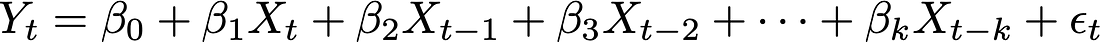

where:

- *Y<sub>t</sub>* is the dependent variable (e.g., sales, temperature, or production).
- *X<sub>t</sub>* is an independent variable (e.g., advertising spending, weather conditions, or economic indicators).
- *k* is the maximum lag length.
- *β<sub>i</sub>* are the coefficients that determine the impact of each lag.
- *ϵ<sub>t</sub>* is the error term.

If β<sub>i</sub> values are large for small i and decrease over time, the effect of X<sub>t</sub> decays rapidly. If β<sub>i</sub> values remain significant over longer lags, past values of X have a prolonged effect. If some β<sub>i</sub> values are negative, the effect of X<sub>t</sub> may be oscillatory (e.g., cycles in economic data).

In [1]:
!pip install --no-cache-dir --disable-pip-version-check -q numpy pandas seaborn matplotlib statsmodels plotly
!pip install --no-cache-dir --disable-pip-version-check -q pandas-datareader featuretools scikit-learn visualization
!pip install --no-cache-dir --disable-pip-version-check -q pillow

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.dates as mdates

from matplotlib.ticker import FuncFormatter

from PIL import Image
from statsmodels.tsa.seasonal import seasonal_decompose

def set_visualization_style():
    """
    Set global matplotlib visualization style parameters.
    """
    plt.rcParams.update({
        "font.family": "serif",
        "axes.labelsize": 12,
        "axes.titlesize": 14,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.grid": False
    })


def set_plot_style(ax, data: pd.DataFrame, time_column, value_columns):
    """
    Set the style for a given plot axis based on the dataframe content.

    Parameters:
        ax (matplotlib.axes.Axes): The axis object to style.
        data (pandas.DataFrame): DataFrame containing time and value columns.
        time_column (str): The name of the time column in the DataFrame.
        value_columns (list): List of value column names.
    """
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_position(("outward", 5))
    ax.spines["bottom"].set_position(("outward", 5))

    data[time_column] = pd.to_datetime(data[time_column])  # Ensure datetime format
    time_range = data[time_column].max() - data[time_column].min()

    # Adjust X-Axis ticks dynamically
    if time_range < pd.Timedelta(days=365):  # If data is shorter than 1 year
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    elif time_range < pd.Timedelta(days=365 * 10):  # If data spans less than 10 years
        ax.xaxis.set_major_locator(mdates.YearLocator(1))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    else:  # For longer datasets, use 50-year intervals
        ax.xaxis.set_major_locator(mdates.YearLocator(50))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    ax.set_xlim(data[time_column].min(), data[time_column].max())

    # Y-Axis scaling based on percentiles
    all_values = np.concatenate(
        [data[col].dropna().values for col in value_columns]
    )
    y_20, y_mean, y_80 = np.percentile(all_values, [20, 50, 80])

    ax.set_yticks([y_20, y_mean, y_80])
    ax.set_yticklabels(
        [f"{int(y_20)}", f"{int(y_mean)}", f"{int(y_80)}"]
    )  

    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))

    if data[time_column].dtype in [np.int64, np.float64]:
        ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x)}"))


def plot_time_series(data: pd.DataFrame, time_column, value_columns, title: str = "Time Series Plot", filename=None):
    """
    Plot time series data from a DataFrame.

    Parameters:
        data (pandas.DataFrame): DataFrame containing time and value data.
        time_column (str): The name of the time column.
        value_columns (list): List of column names to plot.
        title (str, optional): Title of the plot.
        filename (str, optional): Filename to save the plot.
    """
    set_visualization_style()
    fig, ax = plt.subplots(figsize=(10, 5))
    colors = plt.cm.Greys(np.linspace(0.2, 0.8, len(value_columns)))

    data[time_column] = pd.to_datetime(data[time_column])  # Ensure datetime format

    for i, col in enumerate(value_columns):
        ax.plot(data[time_column], data[col], linewidth=2, color=colors[i])
        last_x = data[time_column].iloc[-1] + pd.Timedelta(days=10)
        last_y = data[col].iloc[-1]
        ax.text(last_x, last_y, col, fontsize=12, color=colors[i],
                verticalalignment="center")

    set_plot_style(ax, data, time_column, value_columns)

    if title:
        ax.set_title(title)

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches="tight")
    plt.show()


def plot_decomposition(data: pd.Series, model: str = "additive",
                       title: str = "Time Series Decomposition"):
    """
    Perform and plot seasonal decomposition of a time series.

    Parameters:
        data (pandas.Series): The time series data to decompose.
        model (str): Type of seasonal component ('additive' or 'multiplicative').
        title (str): Title for the decomposition plots.
    """
    set_visualization_style()
    period = max(2, len(data) // 10)
    decomposition = seasonal_decompose(data, model=model, period=period)
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

    axes[0].plot(data, label="Original", color='black')
    axes[0].set_title("Original Series")

    axes[1].plot(decomposition.trend, label="Trend", color='black')
    axes[1].set_title("Trend")

    axes[2].plot(decomposition.seasonal, label="Seasonal", color='black')
    axes[2].set_title("Seasonal")

    axes[3].plot(decomposition.resid, label="Residual", color='black')
    axes[3].set_title("Residual")

    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()

In [4]:
from pandas_datareader import data as web
import statsmodels.api as sm
from datetime import datetime

# Function to fetch CPI data from FRED
def get_fred_data(series_id, start_date="2000-01-01", end_date=None):
    if end_date is None:
        end_date = datetime.now().strftime("%Y-%m-%d")
    df = web.DataReader(series_id, 'fred', start_date, end_date)
    return df.dropna()

# Fetch CPI data
series_id = "CPIAUCSL"  # Consumer Price Index for All Urban Consumers
cpi_data = get_fred_data(series_id)
cpi_data = cpi_data.pct_change().dropna()  

# Prepare DataFrame
cpi_data = cpi_data.rename(columns={series_id: "CPI"})
cpi_data["Date"] = cpi_data.index  


# Create lagged CPI values
for lag in range(1, 3):  # Include 2 lags
    cpi_data[f"CPI_lag{lag}"] = cpi_data["CPI"].shift(lag)

# Drop missing values due to lagging
cpi_data.dropna(inplace=True)

# Define independent and dependent variables
X_lags = ["CPI", "CPI_lag1", "CPI_lag2"]
X_matrix = sm.add_constant(cpi_data[X_lags])  # Add intercept
y_vector = cpi_data["CPI"]  # Target is CPI itself (can be changed)

# Fit the distributed lag model
model = sm.OLS(y_vector, X_matrix).fit()

# Display results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    CPI   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.172e+31
Date:                Mon, 24 Mar 2025   Prob (F-statistic):               0.00
Time:                        18:50:05   Log-Likelihood:                 11316.
No. Observations:                 299   AIC:                        -2.262e+04
Df Residuals:                     295   BIC:                        -2.261e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.508e-18   7.07e-19     12.032      0.0

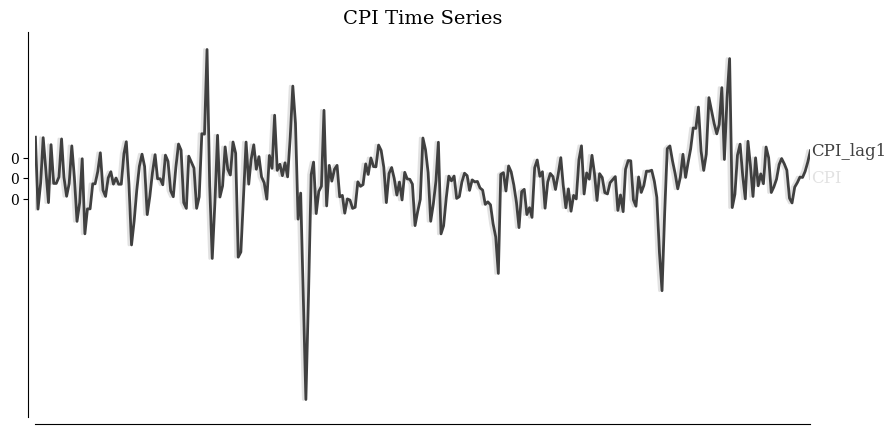

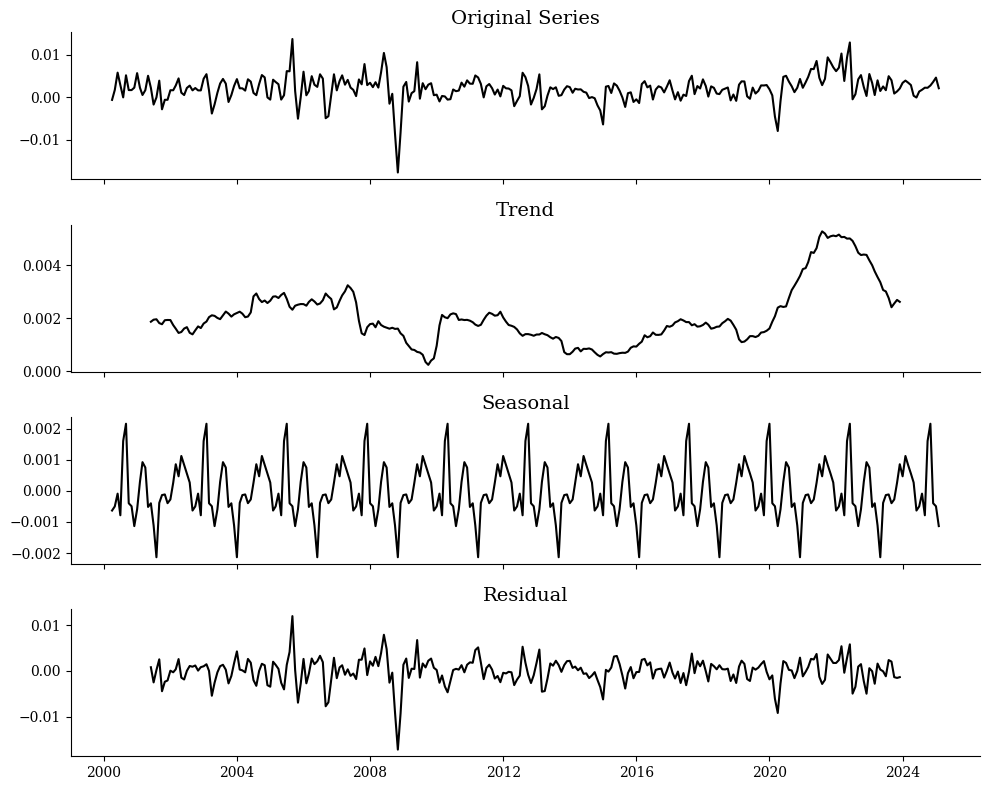

In [5]:
# Visualize CPI data
time_column = "Date"
value_columns = ["CPI", "CPI_lag1"]
plot_time_series(cpi_data, time_column, value_columns, title="CPI Time Series")


# Perform and plot decomposition
plot_decomposition(cpi_data["CPI"], model="additive", title="CPI Decomposition")

In [6]:
## Using AIC to select the optimal number of lags:
import statsmodels.tsa.stattools as ts
# Determine optimal lag length
max_lags = 10
aic_values = []
for lag in range(1, max_lags + 1):
    temp_data = cpi_data.copy()
    for l in range(1, lag + 1):
        temp_data[f"CPI_lag{l}"] = temp_data["CPI"].shift(l)
    temp_data.dropna(inplace=True)
X_lags = ["CPI"] + [f"CPI_lag{l}" for l in range(1, lag + 1)]

X_matrix = sm.add_constant(temp_data[X_lags])
y_vector = temp_data["CPI"]
model = sm.OLS(y_vector, X_matrix).fit()
aic_values.append(model.aic)

# Find the optimal number of lags
optimal_lag = np.argmin(aic_values) + 1
print(f"Optimal number of lags: {optimal_lag}")

Optimal number of lags: 1


#### Methods for Selecting Lags:

- **Information Criteria (AIC/BIC):** Use Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC) to compare models with different lag lengths.

- **Significance of Coefficients:** Drop lags with statistically insignificant coefficients.

- **Partial Autocorrelation Function (PACF):** Examine PACF to determine the number of significant lags.

##### Applications of Distributed Lag Models
Distributed lag models are useful in various fields:

- **Economics:** Modeling the impact of monetary policy changes on inflation and unemployment.
- **Marketing:** Understanding how advertising campaigns affect future sales.
- **Energy Demand Forecasting:** Estimating the delayed impact of temperature changes on electricity consumption.
- **Public Policy:** Measuring how tax changes influence consumer spending over time.

Distributed lag models are a framework to see how past values of an independent variable influence present outcomes.